In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

z = 2
z2 = (1 + z) / 3

In [2]:
with open('rate.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

In [3]:
t_arr = [1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12, 5e12, 1e13]
t_num = len(t_arr)

In [4]:
def get_nij(i, j, t): # nij = dN / (dV dgammae_j dOmegae_i)
    gamma6 = gamma_e_arr[j] / 1e6
    Gamma_IC = 1.1e-12 * z2**4 * gamma6
    
    gamma_max = 1 / (Gamma_IC * (1 / Gamma_IC / gamma_e_arr[j] - t))
    if gamma_max < 0:
        gamma_max = float('inf')
    
    
    nij = 0
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans[i][jp]
            nij += sum_ij
    nij = nij / (Gamma_IC * gamma_e_arr[j]**2)
    return nij

In [5]:
def get_ni(i, nij): # integrate gamma_e (1/gamma_e) nij
    ni = 0
    for j in range(1, 400):
        sum_i = (gamma_e_arr[j] - gamma_e_arr[j-1]) / gamma_e_arr[j] * nij[i][j]
        ni += sum_i
    return ni

In [15]:
def get_Px(ni, Omega_x):
    Px = np.zeros((400, 1))
    for i in range(400): # Omega_x
        for j in range(1, 400): # theta
            if theta_e_arr[j-1] > Omega_x[i]:
                sum_ij = ni[j-1] * (np.sqrt(theta_e_arr[j]**2 - Omega_x[i]**2) - np.sqrt(theta_e_arr[j-1]**2 - Omega_x[i]**2))
                Px[i] += sum_ij
    return Px

In [7]:
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

In [8]:
nij = np.zeros((t_num, 400, 400)) # t theta[i] gamma[j]
for k in range(t_num):
    for i in range(400):
        for j in range(1, 400):
            nij[k][i][j-1] = get_nij(i, j, t_arr[k])

In [10]:
ni = np.zeros((t_num, 400)) # about theta
for k in range(t_num):
    for i in range(400):
        ni[k][i] = get_ni(i, nij[k])

In [16]:
Px = np.zeros((t_num, 400))
for k in range(t_num):
    Px[k] = get_Px(ni[k], Omega_x).reshape(1, 400)

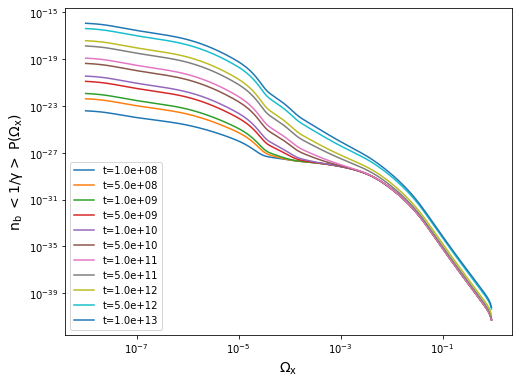

In [22]:
fig = plt.figure(figsize=(8, 6))
for k in range(t_num):
    plt.plot(Omega_x[:-2], Px[k, :-2], label=f't={t_arr[k]:.1e}')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=10)
plt.xlabel('$\mathrm{\Omega_x}$', fontsize = 14)
plt.ylabel('$\mathrm{n_b\ <1/\gamma>\ P(\Omega_x)}$', fontsize = 14)
plt.show()

In [32]:
slop = np.zeros((t_num, 399))
Omega_x = Omega_x.reshape(400, 1)
for k in range(t_num):
    Pxk = Px[k].reshape(400, 1)
    slopk = (Pxk[1:] - Pxk[:-1]) / (Omega_x[1:] - Omega_x[:-1])
    slop[k] = slopk.reshape(1, 399)
    idx_max = np.where(abs(slopk) == max(abs(slopk)))
    print(f't = {t_arr[k]:.1e}, Omega_x = {Omega_x[idx_max]}, slop = {slopk[idx_max]}')

t = 1.0e+08, Omega_x = [1.31916996e-08], slop = [-7.86679054e-17]
t = 5.0e+08, Omega_x = [1.31916996e-08], slop = [-8.57656091e-16]
t = 1.0e+09, Omega_x = [1.31916996e-08], slop = [-2.42336474e-15]
t = 5.0e+09, Omega_x = [1.31916996e-08], slop = [-2.64244289e-14]
t = 1.0e+10, Omega_x = [1.31916996e-08], slop = [-7.46663284e-14]
t = 5.0e+10, Omega_x = [1.31916996e-08], slop = [-9.03276686e-13]
t = 1.0e+11, Omega_x = [1.31916996e-08], slop = [-2.5523992e-12]
t = 5.0e+11, Omega_x = [1.31916996e-08], slop = [-2.78318822e-11]
t = 1.0e+12, Omega_x = [1.31916996e-08], slop = [-7.86448695e-11]
t = 5.0e+12, Omega_x = [1.31916996e-08], slop = [-8.57559734e-10]
t = 1.0e+13, Omega_x = [1.31916996e-08], slop = [-2.42321641e-09]
